# The Perceptron

In this lab session, you will implement a famous classification algorithm: the perceptron.
The model is a follows:

$$f(x) = h(\pmb{w}^T x + b)$$ 

where

$$ 
 h(a) = \left\{ 
  \begin{array}{l l}
    ~1 & \quad \text{if} ~ a > 0\\
    -1 & \quad \text{otherwise}
  \end{array} \right. $$

and $x$ is an example to classify, 
$\pmb{w}$ is a weight vector with same dimension a $x$
and $b$ is a scalar bias.
$\pmb{w}$ and $b$ are the parameters we have to learn.

## Learning the parameters
*In this section, you will calculate the update formula for the parameters $\pmb{w}$ and $b$*

### Objective function

The perceptron learning algorithm is a stochastic gradient descent on the following objective:

$$J_{perceptron}(\pmb{w}, b) = \frac{1}{n} \sum_{i=1}^n \max(0, -(\pmb{w}^T x^{(i)} + b)t^{(i)}) )$$

Note that this objective is always non-negative.
The function $z \mapsto \max(0, -z)$ is plotted below.

Interpretation of the objective: for each misclassified example, e.g. $(\pmb{w}^T x^{(i)} + b)t^{(i)} <0$, we add the classification error $|\pmb{w}^T x^{(i)} + b| = -(\pmb{w}^T x^{(i)} + b)t^{(i)}$ to the objective.
If we decrease the value of the objective function, then we decrease the total error, which will end up reducing the number of misclassified examples. We will end up with a better classifier.

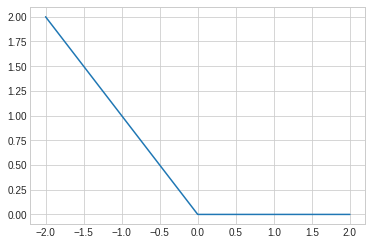

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

xx = np.linspace(-2,2, 1000)
plt.plot(xx, np.maximum(0, -xx))

### Stochastic Gradient Descent
To minimize the objective, we are going to use a stochastic gradient descent algorithm.
It means that we are going to sample __one__ data point stochastically, and update the weights so as to decrease the objective value for this __one__ sample by going in the opposite direction of the gradient.

Now it's up to you !

1. Express the objective function for only one sample $J^{(i)}(\pmb{w}, b)$
2. Express the partial derivatives $\frac{\partial J^{(i)}}{\partial b}$ and $\frac{\partial J^{(i)}}{\partial \pmb{w}}$.   _Help_: split between the cases $(\pmb{w}^T x^{(i)} + b)t^{(i)} < 0$ and $(\pmb{w}^T x^{(i)} + b)t^{(i)} \geq 0$.
3. What happens when $\pmb{w}=0$ and $b=0$?

In [31]:
def objective_function(train_set, weights, bias):
    return np.maximum(0, (np.sum(weights * train_set[:,:-1], axis = 1) + bias) * train_set[:,-1])

In [3]:
def dJdw(train_set, objective):
    result = np.zeros((train_set.shape[0], train_set.shape[1]-1))
    non_zero_i = np.where(objective > 0)[0]
    result[non_zero_i] = - train_set[non_zero_i,:-1] * train_set[non_zero_i,-1].reshape((len(non_zero_i),1))
    return result

In [4]:
def dJdb(train_set, objective):
    result = np.zeros(train_set.shape[0])
    non_zero_i = np.where(objective > 0)[0]
    result[non_zero_i] = -train_set[non_zero_i,-1]
    return result

### Training Algorithm

The learning algorithm is:

 - iterate over samples in the dataset one by one.
 - For each sample, update the parameters with the formula: $b \leftarrow b - \eta \frac{\partial J^{(i)}}{\partial b}$ and $\pmb{w} \leftarrow \pmb{w} - \eta \frac{\partial J^{(i)}}{\partial \pmb{w}}$

We can add a stopping criterion:

 - If all the training samples are well classified, stop. In such a situation, $J_{perceptron}(\theta) = 0$ and the partial derivatives are zero. There is nothing to learn anymore.

## Practice

*In this section, you will implement the formulas derived above.*

### Data pre-processing

We are going to work on the iris dataset. 
We will use only 2 classes: iris with labels 1 and 2, that we will replace by 1 and -1 to match the perceptron's needs. We will also use only 2 features per iris, so that we can visualize the algorithm.

Here is the code that pre-process the data. 
Do not hesitate to look at the *shapes* of each data set to understand what is happening.

In [41]:
# We first load the data set
iris = np.loadtxt('iris.txt')
data = iris

# We are doing BINARY classification, so we will only keep data from 2 classes.
# Here we decide to keep samples with labels 1 and 2.
data = data[data[:,-1]<3,:]
# Here we transform each label 2 into a -1, 
# to have the same labels as in the standard formulation of the perceptron (1 and -1)
data[data[:,-1]==2,-1] = -1

# We keep only 2 features to be able to visualize the decision boundary.
train_cols = [1,3]
# This is a list containing the index of the column containing the labels
target_ind = [data.shape[1] - 1]

# Number of classes
n_classes = 2
# Number of training samples
n_train = 75

# Comment to get non-deterministic results
#np.random.seed(2)

## Shuffle the data set before splitting it between train and test
# First get the indices
inds = np.arange(data.shape[0])
np.random.shuffle(inds)
train_inds = inds[:n_train]
test_inds = inds[n_train:]
    
# Then split the data set
train_set = data[train_inds,:]  # keep the right lines
train_set = train_set[:,train_cols + target_ind]  # keep the right columns
test_set = data[test_inds,:]
test_set = test_set[:,train_cols + target_ind]

# Split the test set: inputs and labels
test_inputs = test_set[:,:-1]
test_labels = test_set[:,-1]

### The perceptron class

We define the class *Perceptron*. As usual, it's a class that has a *train* method to learn the parameters on the *train_set* and a *compute_prediction* method to predict the class of each sample in *test_inputs*.

For this lab session, you have to:

1. Complete the method *train*
2. Complete the method *compute_prediction*


In [39]:
class Perceptron:

    def __init__(self, eta):
        """
        Class constructor initializing the attributes.
        Parameters
        ----------
        eta : float
            Learning rate
        """
        self.eta = eta

    def plot_function(self, train_data, title):
        plt.figure()
        d1 = train_data[train_data[:, -1] > 0]
        d2 = train_data[train_data[:, -1] < 0]
        plt.scatter(d1[:, 0], d1[:, 1], c='b', label='class +1')
        plt.scatter(d2[:, 0], d2[:, 1], c='g', label='class -1')
        x = np.linspace(-10, 10, 100)
        y = -(self.weights[0]*x + self.bias)/self.weights[1]
        plt.plot(x, y, c='r', lw=2, label='y = -(w1*x + b1)/w2')
        plt.xlim(np.min(train_data[:, 0]) - 0.5, np.max(train_data[:, 0]) + 0.5)
        plt.ylim(np.min(train_data[:, 1]) - 0.5, np.max(train_data[:, 1]) + 0.5)
        plt.grid()
        plt.legend(loc='lower right')
        plt.title(title)
        plt.show()

    def train(self, train_data, max_iter=10):
        """
        Train the model on a data matrix by doing a maximum of max_iter epochs.
        (Note: One epoch is one pass over the data set.)
        
        Parameters
        ----------
        train_data : array
            matrix of dimension (n, d+1) where n is the number of samples
            and d is the number of dimensions of each sample. Each line contains
            one input in the d first columns and the label in the column d+1.
        max_iter : int
            Maximal number of epochs(default 10).
        """
        # 1) Parameters Initialization
        # Initialize the weigths to small values and the bias to 0
        self.weights = np.random.rand(train_set.shape[1] - 1)/100
        self.bias = 0
         
        # 2) Training
        # Implement the algorithm presented above
        # iteration is the number of epochs done so far.
        # count is the number of misclassified examples.
        print('Training ...')
        iteration = 0
        while iteration < max_iter:
            self.plot_function(train_data, 'Iteration no: ' + str(iteration))
            # Implement the training algorithm here !
            objectives = objective_function(train_set=train_set, bias=self.bias, weights=self.weights)
            non_zero_i = np.where(objectives > 0)[0]
            if len(non_zero_i) == 0:
                break
                
            delta_w = np.mean(dJdw(objective=objectives, train_set=train_set), axis = 0)
            delta_b = np.mean(dJdb(objective=objectives, train_set=train_set))
            self.weights = self.weights + self.eta * delta_w
            self.bias = self.bias + self.eta * delta_b
            iteration += 1
            
        count = len(non_zero_i)    
        print('Training completed!')
        print("The train error is {:.2f}%".format(100 * float(count)/train_data.shape[0]))

    def compute_predictions(self, test_data):
        """
        Predict the class of each sample in a test matrix
        
        Parameters
        ----------
        test_data : array
            matrix of shape (n,d) where n is the number of samples
            and d is the number of dimensions.
            
        Returns
        -------
        array
            array of shape (n) filled with predicted classes (-1 or 1)
        """
  
        # 1) Calculate the class predicted by the perceptron for each sample
        predictions = np.zeros(test_data.shape[0])
        # Fill here
        
        return predictions

### Training
Now that the class *Perceptron* is complete, we can train it. 
After each epoch, a plot will be displayed.

Training ...


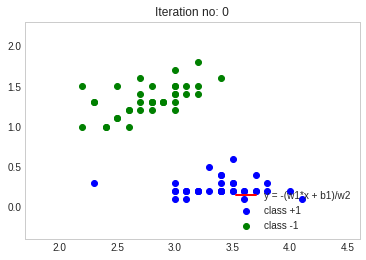

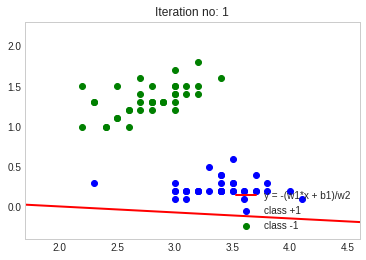

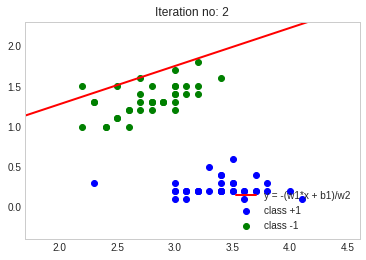

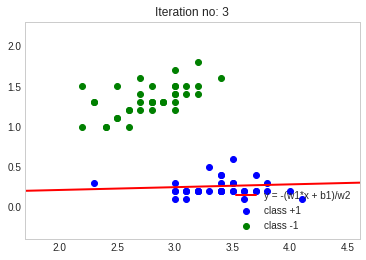

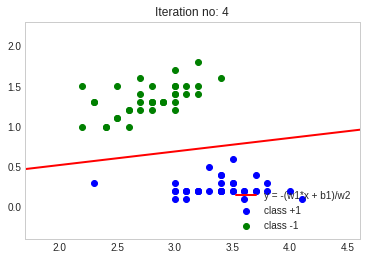

Training completed!
The train error is 0.00%


In [42]:
# The learning rate
eta = 0.001

# Instantiate and train the model
model_perceptron = Perceptron(eta)
model_perceptron.train(train_set, max_iter= 50)

### Testing

Now that our model is trained, we can test it !

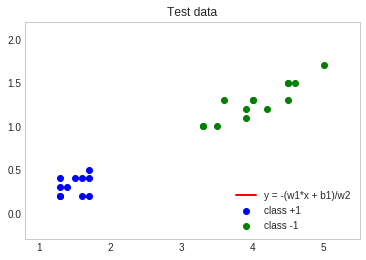

The test error is 100.00%


In [8]:
# Get the classes predicted for the test set
predictions = model_perceptron.compute_predictions(test_inputs)
   
# Measure the error rate
err = 1.0 - np.mean(test_labels==predictions)

model_perceptron.plot_function(test_set, 'Test data')
print("The test error is {:.2f}%".format(100.0 * err))

### If you are done

If you completed everything this far, you can play with the different parameters.
This is good practice to get familiar with hyper parameter tuning.
For instance:

1. Change $\eta$. What is its impact on the training time? and on the quality of the classifier? 
2. Use other Iris features (for instance [1,3] instead of [2,3]).
3. Change the size of the training set. Is there an impact on the performance?